### Libraries used

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA
from IPython import display
import time

### Functions and constants

In [3]:
global T, m
T = 0
m = 0.5

In [4]:
def utility(N, H):
    pho = N/H
    if(pho <= 0.5):
        res = 2*pho
    else:
        res = 2*(m-1)*pho + (2 - m)
    return res

In [5]:
def compute_gain_old(N_1, N_2, H, case, alpha):
    if(case == 'minus'):
        agent_utility = utility(N_1, H)
        new_agent_utility = utility(N_2 + 1, H)
        delta_agent_utility = new_agent_utility - agent_utility
    elif(case == 'plus'):
        agent_utility = utility(N_2, H)
        new_agent_utility = utility(N_1 + 1, H)
        delta_agent_utility = new_agent_utility - agent_utility
        
    return delta_agent_utility

In [6]:
def compute_gain(N_1, N_2, H, case, alpha):
    # minus case: agent move from block 1 to block 2
    if(case == 'minus'):
        agent_utility_1 = utility(N_1, H)
        agent_utility_2 = utility(N_2, H)
        new_agent_utility_1 = utility(N_1 - 1, H)
        new_agent_utility_2 = utility(N_2 + 1, H)
        delta_agent_utility = new_agent_utility_2 - agent_utility_1
        delta_global_utility = (new_agent_utility_1*(N_1 - 1) + new_agent_utility_2*(N_2 + 1)) - (agent_utility_1*N_1 + agent_utility_2*N_2)

    # plus case: agent move from block 2 to block 1
    elif(case == 'plus'):
        agent_utility_1 = utility(N_1, H)
        agent_utility_2 = utility(N_2, H)
        new_agent_utility_1 = utility(N_1 + 1, H)
        new_agent_utility_2 = utility(N_2 - 1, H)
        delta_agent_utility = new_agent_utility_1 - agent_utility_2
        delta_global_utility = (new_agent_utility_1*(N_1 + 1) + new_agent_utility_2*(N_2 - 1)) - (agent_utility_1*N_1 + agent_utility_2*N_2)

    gain = delta_agent_utility + alpha * (delta_global_utility - delta_agent_utility)
        
    return gain

In [7]:
def probability(N_1, N_2, H, case, alpha):
    gain = compute_gain(N_1, N_2, H, case, alpha)
    
    if(T == 0):
        if gain < 0:
            prob = 0
        elif gain > 0:
            prob = 1
        else:
            prob = 0.5
            
    else:
        exp = np.exp(-gain/T)
        prob = 1/(1+exp)
        
    return prob

In [8]:
def create_matrix(N, H, alpha):
    if N/(2*H) >= 0.5:
        i_min = N - H
        i_max = H
    else:
        i_min = 0
        i_max = N

    M = np.zeros((i_max + 1 - i_min, i_max + 1 - i_min))
    
    for i in range(0, i_max + 1 - i_min):
        M_i_plus  = ((N-i-i_min) * (H-i-i_min))/(H*H) * probability(i+i_min, N - i-i_min, H, 'plus', alpha)
        M_i_minus = ((i+i_min) * (H-N+i+i_min))/(H*H) * probability(i+i_min, N - i-i_min, H, 'minus', alpha)
        M_i_i = 1 - M_i_plus - M_i_minus
        
        if(i == 0):
            M[i,i] = M_i_i
            M[i, i+1] = M_i_plus
        
        elif(i == i_max - i_min):
            M[i,i] = M_i_i
            M[i, i-1] = M_i_minus
            
        else:
            M[i,i] = M_i_i
            M[i, i-1] = M_i_minus
            M[i, i+1] = M_i_plus
        
    return M

In [9]:
def initial_vector(i_min, i_max, N):
    array = np.zeros(i_max - i_min + 1)
    array[N - i_min] = 1
    return array

### Analysis

This code calculates the evolution of the number of agents in a block in a 2-blocks city system treating it as a birth-death process using linear algebra.

All you have to do is to choose the total number of agents, *N*, the maximum number of agents per block, *H*, and the initial number of agents in one of the blocks, *initial_number_of_agents*.

In [14]:
def calculation(N, H, alpha, eigenShow = False, plot = False):
    # N is the total number of agents
    # H is the maximum number of agents per block
    
    # minimum and maximum number of agents in a block
    # if total density is greater then 0.5
    if N/(2*H) >= 0.5:
        i_min = N - H
        i_max = H
    
    # if total density is less then 0.5
    else:
        i_min = 0
        i_max = N
    
    # creates the birth-death process matrix
    M = create_matrix(N, H, alpha)
    # actually we need the transpose to do the calculations
    M = np.transpose(M)
    
    # eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(M)
        
    eigenvectors_inv = LA.inv(eigenvectors)

    if eigenShow:
        error = 0.000
        for i in range(len(eigenvalues)):
            if abs(eigenvalues[i] - 1) <= error and all(value >= 0 for value in eigenvectors[:,i]):
                print(eigenvectors[:,i])
    
    
    """
    # being V the vector representing the probability of a block have N_t agents (between i_min and i_max) and M the matrix of the birth-death process,
    # which evolves the system over time, so we want to find the vector V_equi that doesn't change when M is applied in it: M * V_equi = V_equi. So
    # V_equi is the eigenvector of M with eigenvalue 1.
    eigenvalues, eigenvectors = LA.eig(M, left = True, right = False)
    
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real
            
    eigenvectors_inverse = LA.inv(eigenvectors)
    
    D = np.diag(eigenvalues)
    
    # num tests how good is our calculations of the eigenvectors_inverse
    num = LA.norm(np.matmul(eigenvectors, eigenvectors_inverse) - np.identity(len(eigenvalues)))
    print(f"\n How good is eigenvectros_inverse (the closer to 0 the better): {num}")
    """
    
    # P is the initial vector. It represents the initial state of our system, for example, a block with initial_number_of_agents agents.
    # So it is a vector with i_max - i_min + 1 spaces (a block can have from i_min up to i_max agents) with value 0, but the
    # P[initial_number_of_agents] = 1, which represents the inital condition
    initial_number_of_agents = -1
    while initial_number_of_agents > i_max or initial_number_of_agents < i_min:
        initial_number_of_agents = int(input(f"Enter the initial number of agents in block 1. It has to be between {i_min} and {i_max}, closed intervalls."))
        if initial_number_of_agents > i_max or initial_number_of_agents < i_min:
            print("Invalid initial condition")
            time.sleep(2)
            display.clear_output(wait=True)
            
    print("Initial conditions:")
    print(f"Block 1: {initial_number_of_agents} ({initial_number_of_agents/H})")
    print(f"Block 2: {N - initial_number_of_agents} ({(N - initial_number_of_agents)/H})")
    
    P = initial_vector(i_min, i_max, initial_number_of_agents)
    
    # direct multiplication
    a = np.matmul(M,P)
    
    steps = 50000
    for i in range(steps):
        a = np.matmul(M,a)
        if any(value >= 0.999 for value in a):
            break
    
    # checks if the final state has sum 1 of all values (statistically possible)
    summ = 0
    for value in a:
        summ += value
    print(f"if close to 1 the final state is statiscally possible: {summ}")
    
    # here we calculate the time evolution of the system, we apply the M matrix time_steps times in the P
    """
    a = np.matmul(eigenvectors_inverse,P)
    time_steps = 1000
    D_k = np.diag(np.array([x**time_steps for x in eigenvalues]))
    
    a = np.matmul(D_k,a)
        
    a = np.matmul(eigenvectors, a)
    sum = 0
    for value in a:
        sum += value
    
    print(sum)
    """
    count = 0
    maxi = -1
    index = -1
    for i in range(len(a)):
        if a[i] > 0.001:
            count += 1

        if a[i] > maxi:
            maxi = a[i]
            index = i + i_min
    
    print("Final results:")
    if count >= 2:
        print("Multiple outcomes possible")
        print(f"Highest probability: {maxi}")
        print(f"Block 1: {index} ({index/H})")
        print(f"Block 2: {N - index} ({(N - index)/H})")
        print(f"Probabilities sum: {sum(a)}")
    else:
        print("Deterministic")
        print(f"Block 1: {index} ({index/H})")
        print(f"Block 2: {N - index} ({(N - index)/H})")

    if plot:
        plt.figure()
        plt.plot(np.linspace(i_min, i_max, i_max - i_min + 1,endpoint=True), P)
        plt.show()
        
        plt.figure()
        plt.plot(np.linspace(i_min, i_max, i_max - i_min + 1,endpoint=True), a)
        plt.show()

Enter the initial number of agents in block 1. It has to be between 20 and 100, closed intervalls. 85


Initial conditions:
Block 1: 85 (0.85)
Block 2: 35 (0.35)
if close to 1 the final state is statiscally possible: 1.0000000000000002
Final results:
Deterministic
Block 1: 60 (0.6)
Block 2: 60 (0.6)


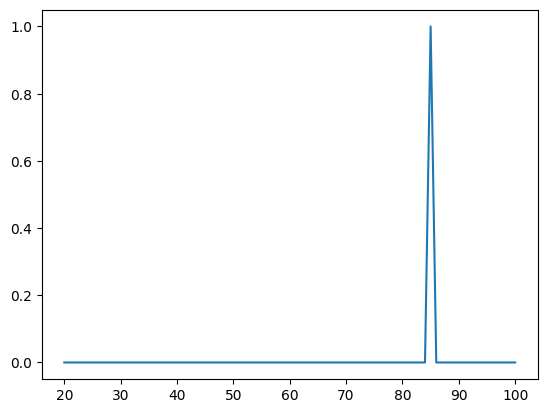

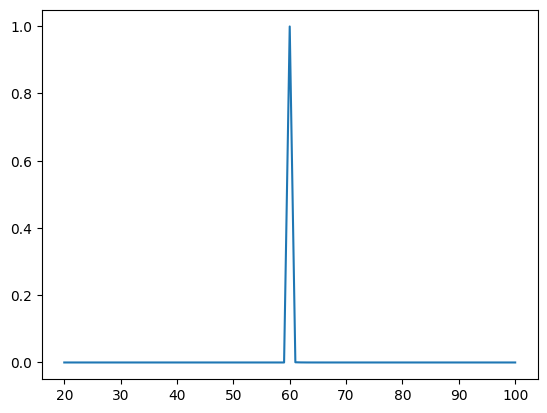

In [20]:
N = 120
H = 100
alpha = 0
plot = True

calculation(N, H, alpha, plot = plot)

## Multiple values for initial conditions and alpha

In [182]:
def calculation_auto(N, H, alpha, initial_number_of_agents, eigenShow = False, plot = False):
    # N is the total number of agents
    # H is the maximum number of agents per block
    
    # minimum and maximum number of agents in a block
    # if total density is greater then 0.5
    if N/(2*H) >= 0.5:
        i_min = N - H
        i_max = H
    
    # if total density is less then 0.5
    else:
        i_min = 0
        i_max = N
    
    # creates the birth-death process matrix
    M = create_matrix(N, H, alpha)
    # actually we need the transpose to do the calculations
    M = np.transpose(M)
    
    # eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(M)
        
    eigenvectors_inv = LA.inv(eigenvectors)

    if eigenShow:
        error = 0.000
        for i in range(len(eigenvalues)):
            if abs(eigenvalues[i] - 1) <= error and all(value >= 0 for value in eigenvectors[:,i]):
                print(eigenvectors[:,i])
    
    
    """
    # being V the vector representing the probability of a block have N_t agents (between i_min and i_max) and M the matrix of the birth-death process,
    # which evolves the system over time, so we want to find the vector V_equi that doesn't change when M is applied in it: M * V_equi = V_equi. So
    # V_equi is the eigenvector of M with eigenvalue 1.
    eigenvalues, eigenvectors = LA.eig(M, left = True, right = False)
    
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real
            
    eigenvectors_inverse = LA.inv(eigenvectors)
    
    D = np.diag(eigenvalues)
    
    # num tests how good is our calculations of the eigenvectors_inverse
    num = LA.norm(np.matmul(eigenvectors, eigenvectors_inverse) - np.identity(len(eigenvalues)))
    print(f"\n How good is eigenvectros_inverse (the closer to 0 the better): {num}")
    """
    
    # P is the initial vector. It represents the initial state of our system, for example, a block with initial_number_of_agents agents.
    # So it is a vector with i_max - i_min + 1 spaces (a block can have from i_min up to i_max agents) with value 0, but the
    # P[initial_number_of_agents] = 1, which represents the inital condition
    if initial_number_of_agents > i_max or initial_number_of_agents < i_min:
        print("Invalid initial condition")
    
    P = initial_vector(i_min, i_max, initial_number_of_agents)
    
    # direct multiplication
    a = np.matmul(M,P)
    
    steps = 100000
    for i in range(steps):
        a = np.matmul(M,a)
        if any(value >= 0.999 for value in a):
            break
    
    # here we calculate the time evolution of the system, we apply the M matrix time_steps times in the P
    """
    a = np.matmul(eigenvectors_inverse,P)
    time_steps = 1000
    D_k = np.diag(np.array([x**time_steps for x in eigenvalues]))
    
    a = np.matmul(D_k,a)
        
    a = np.matmul(eigenvectors, a)
    sum = 0
    for value in a:
        sum += value
    
    print(sum)
    """
    count = 0
    maxi = -1
    index = -1
    for i in range(len(a)):
        if a[i] > 0.001:
            count += 1

        if a[i] > maxi:
            maxi = a[i]
            index = i + i_min
    
    if index == 0 or index == N:
        res = "segregated"
    else:
        res = "homogeneous"

    if plot:
        plt.figure()
        plt.plot(np.linspace(i_min, i_max, i_max - i_min + 1,endpoint=True), P)
        plt.show()
        
        plt.figure()
        plt.plot(np.linspace(i_min, i_max, i_max - i_min + 1,endpoint=True), a)
        plt.show()

    return res

In [183]:
N = 80
H = 100
plot = False

# minimum and maximum number of agents in a block
# if total density is greater then 0.5
if N/(2*H) >= 0.5:
    i_min = N - H
    i_max = H

# if total density is less then 0.5
else:
    i_min = 0
    i_max = N

alphas = np.linspace(0,1,11, endpoint=True)
initials = np.linspace(i_min, i_max, 11, endpoint=True, dtype=int)

results = dict()

for alpha in alphas:
    print(alpha)
    for initial in initials:
        res = calculation_auto(N, H, alpha, initial, plot = plot)
        results[(alpha, initial)] = res

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


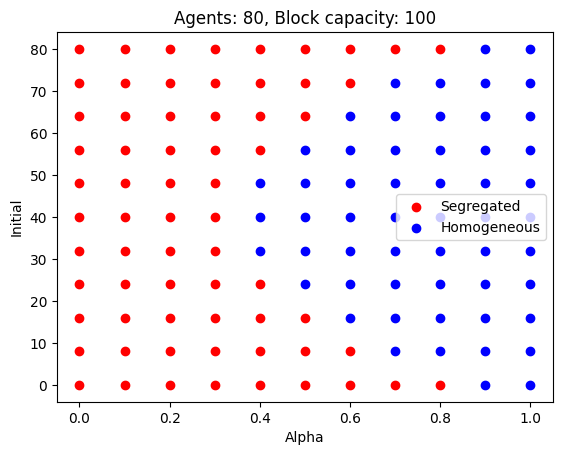

In [184]:
# Separe os dados por categoria
segregated = {key: value for key, value in results.items() if value == 'segregated'}
homogeneous = {key: value for key, value in results.items() if value == 'homogeneous'}

# Extraia as coordenadas para os pontos e suas cores
alpha_segregated, initial_segregated = zip(*segregated.keys())
alpha_homogeneous, initial_homogeneous = zip(*homogeneous.keys())

# Crie o plot
plt.scatter(alpha_segregated, initial_segregated, color='red', label='Segregated')
plt.scatter(alpha_homogeneous, initial_homogeneous, color='blue', label='Homogeneous')

# Adicione legendas e rótulos
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Initial')
plt.title(f'Agents: {N}, Block capacity: {H}')

# Mostre o gráfico
plt.show()
